# Deep Learning assignment

## Imports

In [2]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Use MPS on Apple Silicon if available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


----------------------

## Exploring the dataset

In [3]:
class AccentDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, max_length=16000, num_classes=5):
        self.sample_rate = sample_rate
        self.max_length  = max_length
        self.num_classes = num_classes
        self.files = []

        for root, _, fns in os.walk(data_dir):
            for fn in sorted(fns):
                if not fn.lower().endswith('.wav'):
                    continue
                label = int(fn[0]) - 1
                # keep only accents 1–5 → labels 0–4
                if 0 <= label < self.num_classes:
                    self.files.append(os.path.join(root, fn))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        waveform, sr = torchaudio.load(path)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        waveform = waveform.mean(dim=0, keepdim=True)  # mono
        if waveform.size(1) < self.max_length:
            pad = self.max_length - waveform.size(1)
            waveform = nn.functional.pad(waveform, (0, pad))
        else:
            waveform = waveform[:, :self.max_length]
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-5)
        label = int(os.path.basename(path)[0]) - 1
        return waveform.to(device), torch.tensor(label, dtype=torch.long, device=device)


In [4]:
train_dir = 'Train'        
test_dir  = 'Test set'     

train_ds     = AccentDataset(train_dir,  num_classes=5)
test_ds      = AccentDataset(test_dir,   num_classes=5)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32)

In [5]:
import os
import torchaudio
import numpy as np
from collections import Counter


durations = []
accents   = []
genders   = []

for path in train_ds.files:
    info = torchaudio.info(path)
    dur = info.num_frames / info.sample_rate
    durations.append(dur)
    fn = os.path.basename(path)
    accents.append(int(fn[0]))
    genders.append(fn[1])

# 2) Print stats
print(f"Total train files: {len(durations)}")
print(f"Duration (s): min={min(durations):.2f}, max={max(durations):.2f}, "
      f"mean={np.mean(durations):.2f}, median={np.median(durations):.2f}")

print("Accent distribution:", Counter(accents))
print("Gender distribution:", Counter(genders))


Total train files: 3166
Duration (s): min=1.67, max=12.97, mean=5.26, median=5.04
Accent distribution: Counter({4: 754, 1: 740, 2: 626, 3: 564, 5: 482})
Gender distribution: Counter({'f': 1639, 'm': 1527})


Axes(0.125,0.11;0.775x0.77)
gender    f    m
accent          
1       520  220
2       287  339
3       242  322
4       357  397
5       233  249


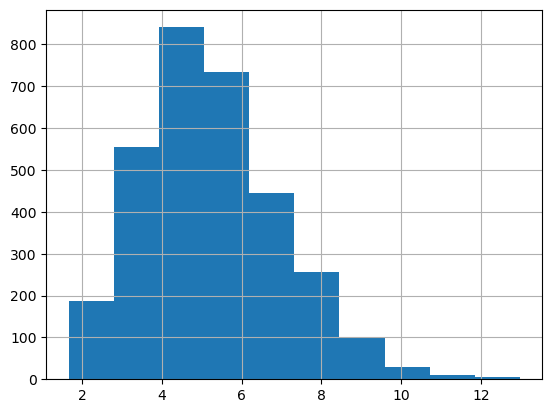

In [6]:
import pandas as pd

df = pd.DataFrame({
    "duration": durations,
    "accent":   accents,
    "gender":   genders,
})


print(df.duration.hist(bins=10))


print(df.groupby(["accent","gender"]).size().unstack(fill_value=0))


In [7]:

import os
import torchaudio
import torch
import matplotlib.pyplot as plt
import pandas as pd


print(f"Found {len(train_ds)} train files, {len(test_ds)} test files")


Found 3166 train files, 298 test files


In [8]:
# Cell 2: gather durations (in seconds) and basic stats
durations = []
for path in train_ds.files:
    info = torchaudio.info(path)
    durations.append(info.num_frames / info.sample_rate)

durations = torch.tensor(durations)
print(f"Durations (s): min={durations.min():.2f}, "
      f"median={durations.median():.2f}, max={durations.max():.2f}")


Durations (s): min=1.67, median=5.03, max=12.97


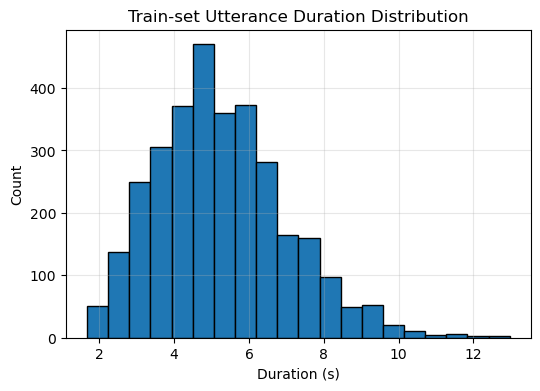

In [9]:
# Cell 3: histogram of utterance lengths
plt.figure(figsize=(6,4))
plt.hist(durations.numpy(), bins=20, edgecolor='black')
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.title("Train-set Utterance Duration Distribution")
plt.grid(alpha=0.3)
plt.show()


In [10]:
rows = []
for path in train_ds.files:
    fn = os.path.basename(path)
    accent = int(fn[0])
    gender = fn[1]
    rows.append({"accent": accent, "gender": gender})
df = pd.DataFrame(rows)
df.head()


,accent,gender
0,1,f
1,1,f
2,1,f
3,1,f
4,1,f


In [11]:
ct = pd.crosstab(df.accent, df.gender)
print("Counts per (accent, gender):")
print(ct)


Counts per (accent, gender):
gender    f    m
accent          
1       520  220
2       287  339
3       242  322
4       357  397
5       233  249


-----

## Dataset import/definitions

In [23]:
class AccentDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, max_length=16000, num_classes=5):
        self.sample_rate = sample_rate
        self.max_length  = max_length
        self.num_classes = num_classes
        self.files = []

        for root, _, fns in os.walk(data_dir):
            for fn in sorted(fns):
                if not fn.lower().endswith('.wav'):
                    continue
                label = int(fn[0]) - 1
                # keep only accents 1–5 → labels 0–4
                if 0 <= label < self.num_classes:
                    self.files.append(os.path.join(root, fn))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        waveform, sr = torchaudio.load(path)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        waveform = waveform.mean(dim=0, keepdim=True)  # mono
        if waveform.size(1) < self.max_length:
            pad = self.max_length - waveform.size(1)
            waveform = nn.functional.pad(waveform, (0, pad))
        else:
            waveform = waveform[:, :self.max_length]
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-5)
        label = int(os.path.basename(path)[0]) - 1
        return waveform.to(device), torch.tensor(label, dtype=torch.long, device=device)


------

## Dataloaders

The dataloaders are used for...

In [24]:
train_dir = 'Train'        
test_dir  = 'Test set'     

train_ds     = AccentDataset(train_dir,  num_classes=5)
test_ds      = AccentDataset(test_dir,   num_classes=5)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32)


---------

## Model - CNN (task 1.2a)

In [25]:
# class RawCNN(nn.Module):
#     def __init__(self, num_classes=5, max_length=16000):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv1d(1, 16, kernel_size=5, padding=2),
#             nn.ReLU(),
#             nn.MaxPool1d(2),
#             nn.Conv1d(16, 32, kernel_size=5, padding=2),
#             nn.ReLU(),
#             nn.MaxPool1d(2),
#         )
#         reduced = max_length // 4  # two poolings of 2
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(32 * reduced, 128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes),
#         )

#     def forward(self, x):
#         return self.fc(self.conv(x))

# model = RawCNN(num_classes=5, max_length=train_ds.max_length).to(device)

class RawCNNVarLenDeep(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv = nn.Sequential(
            # block 1
            nn.Conv1d(1,   64, kernel_size=7, padding=3),  # wider kernel, more feature-maps
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # block 2
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # block 3
            nn.Conv1d(128,256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        # still reduce variable-length to 10 timesteps
        self.global_pool = nn.AdaptiveAvgPool1d(10)

        # adjust classifier input dim = 256 channels × 10 timesteps
        self.classifier = nn.Sequential(
            nn.Flatten(),               # [batch, 256*10 = 2560]
            nn.Linear(256*10, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.global_pool(x)
        return self.classifier(x)




model = RawCNNVarLenDeep(num_classes=5).to(device)

# Loss and optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [26]:
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = correct = total = 0
    with torch.set_grad_enabled(train):
        for X, y in loader:
            logits = model(X)
            loss   = criterion(logits, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total   += X.size(0)
    return total_loss/total, correct/total


### Training loop

In [27]:
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    tl, ta = run_epoch(train_loader, train=True)
    sl, sa = run_epoch(test_loader,  train=False)  
    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {tl:.4f}, Acc: {ta:.4f} | "
          f"Test  Loss: {sl:.4f}, Acc: {sa:.4f}")



Epoch 01 | Train Loss: 1.6158, Acc: 0.2495 | Test  Loss: 1.7782, Acc: 0.1812
Epoch 02 | Train Loss: 1.5396, Acc: 0.2884 | Test  Loss: 1.7434, Acc: 0.2047
Epoch 03 | Train Loss: 1.5277, Acc: 0.2997 | Test  Loss: 1.7341, Acc: 0.1946
Epoch 04 | Train Loss: 1.5085, Acc: 0.3133 | Test  Loss: 1.7630, Acc: 0.1913
Epoch 05 | Train Loss: 1.5079, Acc: 0.3067 | Test  Loss: 1.8297, Acc: 0.1711
Epoch 06 | Train Loss: 1.4825, Acc: 0.3307 | Test  Loss: 1.8164, Acc: 0.1946
Epoch 07 | Train Loss: 1.4752, Acc: 0.3320 | Test  Loss: 1.9189, Acc: 0.1779
Epoch 08 | Train Loss: 1.4780, Acc: 0.3323 | Test  Loss: 1.7614, Acc: 0.2047
Epoch 09 | Train Loss: 1.4498, Acc: 0.3380 | Test  Loss: 1.8337, Acc: 0.1779
Epoch 10 | Train Loss: 1.4432, Acc: 0.3443 | Test  Loss: 1.9310, Acc: 0.2047


-------------------

In [43]:
import torch
print("Train labels:", torch.bincount(torch.tensor([y for _,y in train_ds])))
print("Test  labels:", torch.bincount(torch.tensor([y for _,y in test_ds])))



Train labels: tensor([740, 626, 564, 754, 482])
Test  labels: tensor([54, 58, 65, 62, 59])


-------

## Task 1.2b - mel spectogram

In [4]:
# Cell A: Imports & device
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import os

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Device:", device)


Device: mps


In [13]:
# Cell B: Log‐Mel transforms & DataLoaders
mel_spec      = MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=80)
db_transform  = AmplitudeToDB()

class LogMelDataset(Dataset):
    def __init__(self, data_dir, mel_spec, dbt, max_length=16000, num_classes=5):
        self.mel, self.dbt = mel_spec, dbt
        self.max_length   = max_length
        self.files        = []
        for root,_,fns in os.walk(data_dir):
            for fn in sorted(fns):
                if fn.lower().endswith('.wav'):
                    label = int(fn[0]) - 1
                    if 0 <= label < num_classes:
                        self.files.append((os.path.join(root,fn), label))
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        path,label = self.files[idx]
        wav, sr    = torchaudio.load(path)
        if sr!=16000:
            wav = torchaudio.transforms.Resample(sr,16000)(wav)
        wav = wav.mean(0,keepdim=True)
        if wav.size(1) < self.max_length:
            pad = self.max_length - wav.size(1)
            wav = nn.functional.pad(wav,(0,pad))
        else:
            wav = wav[:,:self.max_length]
        spec   = self.mel(wav)
        logspec= self.dbt(spec)
        logspec= (logspec - logspec.mean())/(logspec.std()+1e-5)
        return logspec.to(device), torch.tensor(label, device=device)

logmel_train_ds = LogMelDataset("Train", mel_spec, db_transform)
logmel_test_ds  = LogMelDataset("Test set", mel_spec, db_transform)
logmel_train_loader = DataLoader(logmel_train_ds, batch_size=32, shuffle=True)
logmel_test_loader  = DataLoader(logmel_test_ds,  batch_size=32)



# ─── Cell G: AugmentedLogMelDataset ─────────────────────────────────────
import random
class AugmentedLogMelDataset(LogMelDataset):
    def __getitem__(self, idx):
        # 1) Load & pad/truncate waveform (same as LogMelDataset)
        wav, label = super(LogMelDataset, self).__getitem__(idx)  # gets [1,max_len]
        
        # 2) Time-shift ±10%
        max_shift = int(0.1 * self.max_length)
        off = random.randint(-max_shift, max_shift)
        if off>0:
            wav = torch.cat([wav[:,off:], torch.zeros(1,off,device=wav.device)], dim=1)
        elif off<0:
            wav = torch.cat([torch.zeros(1,-off,device=wav.device), wav[:,:off]],   dim=1)
        
        # 3) Add Gaussian noise (std=0.05)
        wav = wav + torch.randn_like(wav) * 0.05
        
        # 4) Recompute log-mel
        spec    = mel_spec(wav)
        logspec = db_transform(spec)
        logspec = (logspec - logspec.mean())/(logspec.std()+1e-5)
        return logspec.to(device), label



In [15]:
# ─── Cell H: rebuild augmented loader & retrain ──────────────────────────
aug_logmel_train_ds     = AugmentedLogMelDataset("Train", mel_spec, db_transform)
aug_logmel_train_loader = DataLoader(aug_logmel_train_ds, batch_size=32, shuffle=True)

# then rerun your existing train loop (Cells D–F) but with
#   run_logmel_epoch(aug_logmel_train_loader, True)
# instead of the clean loader.


In [16]:
# Cell C: Minimal Log-Mel CNN
class LogMel_CNN_Min(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64,128, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        flat_size  = 128 * (80//8) * (100//8)  # 128*10*12=15360
        self.fc1   = nn.Linear(flat_size, 256)
        self.fc2   = nn.Linear(256, 5)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

logmel_model = LogMel_CNN_Min().to(device)



# ─── Cell I: Deeper LogMel CNN ───────────────────────────────────────────
class LogMel_CNN_Deep(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch), nn.ReLU(),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch), nn.ReLU(),
                nn.MaxPool2d(2,2)
            )
        self.b1 = block(1,  32)  # → [B,32,40,50]
        self.b2 = block(32, 64)  # → [B,64,20,25]
        self.b3 = block(64,128)  # → [B,128,10,12]
        flat = 128 * 10 * 12    # 15360
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat, 512), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        return self.fc(x)

logmel_model = LogMel_CNN_Deep().to(device)



In [17]:
# Cell D: Loss, Optimizer & Scheduler
import torch.nn as nn
import torch.optim as optim

criterion        = nn.CrossEntropyLoss()
logmel_optimizer = optim.Adam(
    logmel_model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)
scheduler_lm     = optim.lr_scheduler.StepLR(
    logmel_optimizer,
    step_size=5,
    gamma=0.5
)

# Cell E: run_logmel_epoch Function
def run_logmel_epoch(loader, train=True):
    model = logmel_model
    if train:
        model.train()
    else:
        model.eval()
    total_loss = correct = total = 0
    with torch.set_grad_enabled(train):
        for X, y in loader:
            logits = model(X)
            loss   = criterion(logits, y)
            if train:
                logmel_optimizer.zero_grad()
                loss.backward()
                logmel_optimizer.step()
            total_loss += loss.item() * X.size(0)
            preds      = logits.argmax(dim=1)
            correct   += (preds == y).sum().item()
            total     += X.size(0)
    return total_loss/total, correct/total

# Cell F: Training Loop (Log-Mel CNN)
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = run_logmel_epoch(logmel_train_loader, train=True)
    scheduler_lm.step()  # step the learning rate
    te_loss, te_acc = run_logmel_epoch(logmel_test_loader, train=False)
    print(f"[LogMel] Epoch {epoch:02d} | "
          f"LR {scheduler_lm.get_last_lr()[0]:.1e} | "
          f"Train Acc: {tr_acc:.3f} | Test Acc: {te_acc:.3f}")


[LogMel] Epoch 01 | LR 1.0e-03 | Train Acc: 0.246 | Test Acc: 0.191
[LogMel] Epoch 02 | LR 1.0e-03 | Train Acc: 0.269 | Test Acc: 0.191
[LogMel] Epoch 03 | LR 1.0e-03 | Train Acc: 0.321 | Test Acc: 0.198
[LogMel] Epoch 04 | LR 1.0e-03 | Train Acc: 0.476 | Test Acc: 0.205
[LogMel] Epoch 05 | LR 5.0e-04 | Train Acc: 0.595 | Test Acc: 0.255
[LogMel] Epoch 06 | LR 5.0e-04 | Train Acc: 0.686 | Test Acc: 0.238
[LogMel] Epoch 07 | LR 5.0e-04 | Train Acc: 0.723 | Test Acc: 0.228
[LogMel] Epoch 08 | LR 5.0e-04 | Train Acc: 0.746 | Test Acc: 0.255
[LogMel] Epoch 09 | LR 5.0e-04 | Train Acc: 0.749 | Test Acc: 0.235
[LogMel] Epoch 10 | LR 2.5e-04 | Train Acc: 0.775 | Test Acc: 0.255


In [10]:
# Cell D (part 1): Loss & Optimizer
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
logmel_optimizer = optim.Adam(logmel_model.parameters(), lr=1e-3, weight_decay=1e-4)


In [11]:
# Cell D (part 2): Scheduler
scheduler_lm = torch.optim.lr_scheduler.StepLR(logmel_optimizer, step_size=5, gamma=0.5)


In [12]:
# Cell E & F: run_logmel_epoch & Training Loop
def run_logmel_epoch(loader, train=True):
    model = logmel_model
    model.train() if train else model.eval()
    total_loss = correct = total = 0
    for X, y in loader:
        logits = model(X)
        loss   = criterion(logits, y)
        if train:
            logmel_optimizer.zero_grad()
            loss.backward()
            logmel_optimizer.step()
        total_loss += loss.item() * X.size(0)
        correct    += (logits.argmax(1) == y).sum().item()
        total      += X.size(0)
    return total_loss/total, correct/total

for epoch in range(1, 11):
    tr_loss, tr_acc = run_logmel_epoch(logmel_train_loader, True)
    scheduler_lm.step()
    te_loss, te_acc = run_logmel_epoch(logmel_test_loader, False)
    print(f"[LogMel] Epoch {epoch:02d} | "
          f"LR {scheduler_lm.get_last_lr()[0]:.1e} | "
          f"Train Acc: {tr_acc:.3f} | Test Acc: {te_acc:.3f}")


[LogMel] Epoch 01 | LR 1.0e-03 | Train Acc: 0.915 | Test Acc: 0.238
[LogMel] Epoch 02 | LR 1.0e-03 | Train Acc: 0.946 | Test Acc: 0.245
[LogMel] Epoch 03 | LR 1.0e-03 | Train Acc: 0.957 | Test Acc: 0.248
[LogMel] Epoch 04 | LR 1.0e-03 | Train Acc: 0.965 | Test Acc: 0.232
[LogMel] Epoch 05 | LR 5.0e-04 | Train Acc: 0.952 | Test Acc: 0.225
[LogMel] Epoch 06 | LR 5.0e-04 | Train Acc: 0.984 | Test Acc: 0.232
[LogMel] Epoch 07 | LR 5.0e-04 | Train Acc: 0.993 | Test Acc: 0.228
[LogMel] Epoch 08 | LR 5.0e-04 | Train Acc: 0.996 | Test Acc: 0.228
[LogMel] Epoch 09 | LR 5.0e-04 | Train Acc: 0.998 | Test Acc: 0.218
[LogMel] Epoch 10 | LR 2.5e-04 | Train Acc: 1.000 | Test Acc: 0.235


-----------

## Task 1.2b - bad version


### Importing and assigning transformation from torchaudio

In [71]:
import torchaudio.transforms as T


mfcc_transform = T.MFCC(
    sample_rate=16000,
    n_mfcc=40,            # common choice: 13–40 coefficients
    melkwargs={
        "n_fft": 400,      # 25 ms window @16 kHz
        "hop_length": 160, # 10 ms hop
        "n_mels": 64
    }
)


### New MFCCdataset class (like the AccentDataset class, but now for MFCC)

In [72]:
class MFCCDataset(Dataset):
    def __init__(
        self,
        data_dir,
        transform,
        num_classes=5,
        sample_rate=16000,
        max_length=16000
    ):
        self.transform    = transform
        self.num_classes  = num_classes
        self.sample_rate  = sample_rate
        self.max_length   = max_length
        self.files        = []
        for root, _, fns in os.walk(data_dir):
            for fn in sorted(fns):
                if not fn.lower().endswith('.wav'):
                    continue
                lbl = int(fn[0]) - 1
                if 0 <= lbl < num_classes:
                    self.files.append((os.path.join(root, fn), lbl))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path, label = self.files[idx]
        wav, sr = torchaudio.load(path)
        # resample if needed
        if sr != self.sample_rate:
            wav = T.Resample(sr, self.sample_rate)(wav)
        wav = wav.mean(dim=0, keepdim=True)      # mono

        # pad or truncate waveform → fixed max_length
        if wav.size(1) < self.max_length:
            pad = self.max_length - wav.size(1)
            wav = nn.functional.pad(wav, (0, pad))
        else:
            wav = wav[:, :self.max_length]

        # now transform to MFCC → all outputs share same T
        mfcc = self.transform(wav)               # [1, n_mfcc, T_fixed]
        # per–feature normalization
        mfcc = (mfcc - mfcc.mean(dim=-1,keepdim=True)) / (
               mfcc.std(dim=-1, keepdim=True) + 1e-5)

        return mfcc.to(device), torch.tensor(label, device=device)


### MFCC Dataloaders


In [74]:

mfcc_train_ds = MFCCDataset(
    'Train',
    transform=mfcc_transform,
    num_classes=5,
    max_length=16000
)
mfcc_test_ds = MFCCDataset(
    'Test set',
    transform=mfcc_transform,
    num_classes=5,
    max_length=16000
)

mfcc_train_loader = DataLoader(
    mfcc_train_ds,
    batch_size=32,
    shuffle=True
)
mfcc_test_loader = DataLoader(
    mfcc_test_ds,
    batch_size=32
)



### 2D CNN

In [79]:
import math

class MFCC_CNN(nn.Module):
    def __init__(self, num_classes=5, n_mfcc=40, hop_length=160, max_length=16000):
        super().__init__()
        # 2×2 pooling twice on both axes
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d((2,2)),
            # output shape: [B, 32, freq_dim=10, time_dim=25]
        )
        freq_dim = n_mfcc // 4             # 40//4=10
        time_steps = math.ceil(max_length/hop_length) // 4  # 100//4=25
        flat_size = 32 * freq_dim * time_steps  # 32*10*25=8000

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# re-instantiate your MFCC model
mfcc_model = MFCC_CNN(num_classes=5).to(device)


### Train/test loop

In [80]:

criterion    = nn.CrossEntropyLoss()
mfcc_optimizer = optim.Adam(mfcc_model.parameters(), lr=1e-3)

def run_mfcc_epoch(loader, train=True):
    model = mfcc_model
    model.train() if train else model.eval()
    total_loss = correct = total = 0
    with torch.set_grad_enabled(train):
        for X, y in loader:
            logits = model(X)
            loss   = criterion(logits, y)
            if train:
                mfcc_optimizer.zero_grad()
                loss.backward()
                mfcc_optimizer.step()
            total_loss += loss.item() * X.size(0)
            correct    += (logits.argmax(1) == y).sum().item()
            total      += X.size(0)
    return total_loss/total, correct/total

for epoch in range(1, 11):
    tr_l, tr_a = run_mfcc_epoch(mfcc_train_loader, train=True)
    te_l, te_a = run_mfcc_epoch(mfcc_test_loader,  train=False)
    print(f"[MFCC] Epoch {epoch:02d} | Train Acc: {tr_a:.4f} | Test Acc: {te_a:.4f}")


[MFCC] Epoch 01 | Train Acc: 0.2277 | Test Acc: 0.2081
[MFCC] Epoch 02 | Train Acc: 0.2401 | Test Acc: 0.2114
[MFCC] Epoch 03 | Train Acc: 0.2394 | Test Acc: 0.2081
[MFCC] Epoch 04 | Train Acc: 0.2527 | Test Acc: 0.2047
[MFCC] Epoch 05 | Train Acc: 0.2865 | Test Acc: 0.2047
[MFCC] Epoch 06 | Train Acc: 0.3013 | Test Acc: 0.2114
[MFCC] Epoch 07 | Train Acc: 0.3092 | Test Acc: 0.2215
[MFCC] Epoch 08 | Train Acc: 0.2944 | Test Acc: 0.1980
[MFCC] Epoch 09 | Train Acc: 0.3159 | Test Acc: 0.2114
[MFCC] Epoch 10 | Train Acc: 0.3099 | Test Acc: 0.2215


In [81]:
# Cell 11: rebuild optimizer & scheduler for MFCC model
mfcc_optimizer = optim.Adam(
    mfcc_model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)
scheduler = optim.lr_scheduler.StepLR(
    mfcc_optimizer,
    step_size=5,
    gamma=0.5
)


In [82]:
# Cell 12: train for 10 epochs, stepping the LR scheduler each epoch
for epoch in range(1, 11):
    tr_l, tr_a = run_mfcc_epoch(mfcc_train_loader, train=True)
    scheduler.step()   # decay LR if needed
    te_l, te_a = run_mfcc_epoch(mfcc_test_loader, train=False)
    print(f"[Sched] E{epoch:02d} | LR {scheduler.get_last_lr()[0]:.1e} | "
          f"Train Acc {tr_a:.3f} | Test Acc {te_a:.3f}")


[Sched] E01 | LR 1.0e-03 | Train Acc 0.320 | Test Acc 0.228
[Sched] E02 | LR 1.0e-03 | Train Acc 0.358 | Test Acc 0.248
[Sched] E03 | LR 1.0e-03 | Train Acc 0.340 | Test Acc 0.218
[Sched] E04 | LR 1.0e-03 | Train Acc 0.373 | Test Acc 0.225
[Sched] E05 | LR 5.0e-04 | Train Acc 0.399 | Test Acc 0.198
[Sched] E06 | LR 5.0e-04 | Train Acc 0.399 | Test Acc 0.221
[Sched] E07 | LR 5.0e-04 | Train Acc 0.436 | Test Acc 0.255
[Sched] E08 | LR 5.0e-04 | Train Acc 0.425 | Test Acc 0.238
[Sched] E09 | LR 5.0e-04 | Train Acc 0.440 | Test Acc 0.248
[Sched] E10 | LR 2.5e-04 | Train Acc 0.462 | Test Acc 0.248


In [83]:
# Cell 13: quick ablation over dropout rates and BN on/off
from copy import deepcopy

def ablate(dropout, use_bn):
    m = deepcopy(mfcc_model)
    # adjust dropout & batchnorm modules
    for module in m.modules():
        if isinstance(module, nn.Dropout):
            module.p = dropout
        if isinstance(module, nn.BatchNorm2d) and not use_bn:
            # replace BN with identity
            setattr(module, "forward", lambda x: x)
    opt = optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-4)
    for _ in range(5):
        _ = run_mfcc_epoch(mfcc_train_loader, train=True)
    _, acc = run_mfcc_epoch(mfcc_test_loader, train=False)
    return acc

results = {
    f"do={d}_bn={bn}": ablate(d, bn)
    for d in [0.0, 0.3, 0.5]
    for bn in [False, True]
}
print("Ablation results (Test Acc):", results)


Ablation results (Test Acc): {'do=0.0_bn=False': 0.26174496644295303, 'do=0.0_bn=True': 0.24161073825503357, 'do=0.3_bn=False': 0.2516778523489933, 'do=0.3_bn=True': 0.2348993288590604, 'do=0.5_bn=False': 0.22483221476510068, 'do=0.5_bn=True': 0.21140939597315436}


### Augmenting on previous MFCC

In [ ]:
# Cell 8‑c: Build augmented MFCC train loader (replace original mfcc_train_loader)
import random

class AugmentedMFCCDataset(MFCCDataset):
    def __getitem__(self, idx):
        # load fixed‑length waveform & label
        wav, label = super(MFCCDataset, self).__getitem__(idx)  # [1, max_length]
        # random time‑shift ±10%
        max_shift = int(0.1 * self.max_length)
        offset = random.randint(-max_shift, max_shift)
        if offset > 0:
            wav = torch.cat([wav[:, offset:], torch.zeros(1, offset, device=wav.device)], dim=1)
        elif offset < 0:
            wav = torch.cat([torch.zeros(1, -offset, device=wav.device), wav[:, :offset]], dim=1)
        # additive Gaussian noise (SNR ~20dB)
        noise = torch.randn_like(wav) * 0.05
        wav = wav + noise
        # recompute MFCC
        mfcc = mfcc_transform(wav)
        mfcc = (mfcc - mfcc.mean(dim=-1, keepdim=True)) / (mfcc.std(dim=-1, keepdim=True) + 1e-5)
        return mfcc.to(device), label

aug_train_ds = AugmentedMFCCDataset(
    'Train',
    transform=mfcc_transform,
    num_classes=5,
    max_length=16000
)
aug_train_loader = DataLoader(aug_train_ds, batch_size=32, shuffle=True)





In [86]:
# Cell 12: train for 10 epochs, stepping the LR scheduler each epoch
for epoch in range(1, 11):
    tr_l, tr_a = run_mfcc_epoch(mfcc_train_loader, train=True)
    scheduler.step()   # decay LR if needed
    te_l, te_a = run_mfcc_epoch(mfcc_test_loader, train=False)
    print(f"[Sched] E{epoch:02d} | LR {scheduler.get_last_lr()[0]:.1e} | "
          f"Train Acc {tr_a:.3f} | Test Acc {te_a:.3f}")


[Sched] E01 | LR 2.5e-04 | Train Acc 0.597 | Test Acc 0.255


KeyboardInterrupt: 

In [87]:
# Cell 12‑b: Training loop using augmented data and scheduler

# Rebuild optimizer and scheduler after kernel reset
mfcc_optimizer = optim.Adam(mfcc_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(mfcc_optimizer, step_size=5, gamma=0.5)

for epoch in range(1, 11):
    # train on augmented data
    tr_l, tr_a = run_mfcc_epoch(aug_train_loader, train=True)
    scheduler.step()
    # test on clean test set
    te_l, te_a = run_mfcc_epoch(mfcc_test_loader, train=False)
    print(f"[Aug+Sched] E{epoch:02d} | LR {scheduler.get_last_lr()[0]:.1e} | "
          f"Train Acc {tr_a:.3f} | Test Acc {te_a:.3f}")



NotImplementedError: Subclasses of Dataset should implement __getitem__.